In [1]:
# all the libs
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torchvision import datasets, transforms, models

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Data Pre-Processing
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# Set the root directory where "RealWaste" is located
data_dir = '/content/drive/MyDrive/Colab Notebooks/project/realwaste-main/RealWaste'

# Create the dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=None)

# Define the transformation pipeline
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

class SubsetWithTransform(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return self.transform(x), y
    def __len__(self):
        return len(self.subset)

# No transform in ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=None)

# calculate the sizes
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% train
test_size = total_size - train_size

# Split
db_train, db_test = random_split(dataset, [train_size, test_size])

# Wrap with transforms
db_train = SubsetWithTransform(db_train, transform_train)
db_test = SubsetWithTransform(db_test, transform_test)

# Define the data loaders
loader_train = DataLoader(db_train, batch_size=32, shuffle=True, drop_last=True)
loader_test = DataLoader(db_test, batch_size=32, shuffle=False)

In [4]:
# training utils
from torch import nn
import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def fit_one_epoch(model, opt, loader):
    model.train(True)
    loss = nn.CrossEntropyLoss()
    losses, accuracies = [], []
    for images, labels in tqdm.tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        l = loss(pred, labels)
        acc = (pred.argmax(1) == labels).float().mean()

        l.backward()
        opt.step()
        opt.zero_grad()

        losses.append(l.detach().item())
        accuracies.append(acc.detach().item())
    return np.mean(losses), np.mean(accuracies)

@torch.no_grad()
def eval(model, loader):
    model.train(False)
    loss = nn.CrossEntropyLoss()
    accuracies, losses = [], []
    for images, labels in tqdm.tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        acc = (pred.argmax(1) == labels).float().mean()
        l = loss(pred, labels)

        accuracies.append(acc.detach().item())
        losses.append(l.detach().item())
    return np.mean(losses), np.mean(accuracies)


def fit(model, loader_train, loader_val, epochs=50, opt=None):
    assert opt is not None
    hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc = [], [], [], []
    for epoch in range(epochs):
        val_l, val_acc = eval(model, loader_val)
        tr_l, tr_acc = fit_one_epoch(model, opt, loader_train)

        print(f"Finished epoch {epoch} of {epochs}: Train Loss = {tr_l:.3f}  Val Loss = {val_l:.3f}   Train Acc = {tr_acc:.3f}   Val Acc = {val_acc:.3f}", flush=True)
        hist_tr_loss.append(tr_l)
        hist_val_loss.append(val_l)
        hist_tr_acc.append(tr_acc)
        hist_val_acc.append(val_acc)
    return hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc

def plot_training_history(hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc):
    plt.subplot(1, 2, 1)
    plt.plot(hist_tr_acc, label='train accuracy')
    plt.plot(hist_val_acc, label='val accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(hist_tr_loss, label='train loss')
    plt.plot(hist_val_loss, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

In [5]:
# Train
def train(model, loader_train, loader_test, epochs=5, lr=0.01):

  # Define the optimizer
  opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

  # Fit the model to our data
  hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc = fit(model, loader_train, loader_test, epochs=epochs, opt=opt)

  # eval
  l, acc = eval(model, loader_test)
  plot_training_history(hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc)
  print(f'Test accuracy: {acc*100:.2f}%')
  print(f'Test loss: {l:.3f}')

In [6]:
# Fine tuning
def fine_tuning(model, loader_train, loader_test, epochs=2, lr=0.001):

    # Unfreeze the entire model for fine-tuning
  for p in model.parameters():
      p.requires_grad = True

  # Define optimizer
  params = [p for p in model.parameters() if p.requires_grad]
  opt = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)

  # Training
  hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc = fit(model, loader_train, loader_test, epochs=epochs, opt=opt)

  # Testing
  loader_test = DataLoader(db_test, batch_size=64, shuffle=False)
  l, acc = eval(model, loader_test)
  plot_training_history(hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc)
  print(f'Test accuracy: {acc*100:.2f}%')
  print(f'Test loss: {l:.3f}')

In [15]:
import seaborn as sns

@torch.no_grad()
def evaluate_metrics(model, loader):
    model.eval()
    y_pred = []
    y_true = []

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

    # Unique class labels from the dataset
    labels_list = list(range(len(dataset.classes)))

    # Compute metrics
    cm = confusion_matrix(y_true, y_pred, labels=labels_list)
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, labels=labels_list, average=None)
    recall = recall_score(y_true, y_pred, labels=labels_list, average=None)
    f1 = f1_score(y_true, y_pred, labels=labels_list, average=None)

    # Confusion Matrix plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print(f"\nAccuracy: {acc:.4f}")
    for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
        class_name = dataset.classes[i]
        print(f"Class {i} ({class_name}): Precision: {p:.4f}, Recall: {r:.4f}, F1 Score: {f:.4f}")

    # Macro-averaged scores
    macro_precision = precision_score(y_true, y_pred, average='macro')
    macro_recall = recall_score(y_true, y_pred, average='macro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')

    print(f"\nMacro-Averaged Metrics:")
    print(f"Precision: {macro_precision:.4f}")
    print(f"Recall:    {macro_recall:.4f}")
    print(f"F1 Score:  {macro_f1:.4f}")

In [13]:
# train-fine-tune-pipeline
def pipeline(model):
  global db_train, db_test, loader_train, loader_test

  # Define the model for 9-class classification
  num_features = model.classifier.in_features
  model.classifier = nn.Linear(num_features, 9)

  # Move entire model to device
  model = model.to(device)

  # Freeze feature extractor
  for param in model.features.parameters():
      param.requires_grad = False

  # Test the model with one batch to confirm it works
  image_batch, label_batch = db_train[0]
  feature_batch = model(image_batch[None].to(device))

  # Train the model
  train(model, loader_train, loader_test, epochs=8, lr = 0.01)

  # fine tune
  fine_tuning(model, loader_train, loader_test, epochs=10, lr=0.001)

  return model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 118/118 [00:48<00:00,  2.41it/s]

Finished epoch 0 of 8: Train Loss = 1.089  Val Loss = 2.261   Train Acc = 0.624   Val Acc = 0.099



100%|██████████| 118/118 [00:50<00:00,  2.35it/s]

Finished epoch 1 of 8: Train Loss = 0.615  Val Loss = 0.697   Train Acc = 0.788   Val Acc = 0.759



100%|██████████| 118/118 [00:49<00:00,  2.39it/s]

Finished epoch 2 of 8: Train Loss = 0.531  Val Loss = 0.594   Train Acc = 0.814   Val Acc = 0.799



100%|██████████| 118/118 [00:48<00:00,  2.43it/s]

Finished epoch 3 of 8: Train Loss = 0.450  Val Loss = 0.613   Train Acc = 0.841   Val Acc = 0.789



100%|██████████| 118/118 [00:49<00:00,  2.40it/s]

Finished epoch 4 of 8: Train Loss = 0.472  Val Loss = 0.601   Train Acc = 0.832   Val Acc = 0.794



100%|██████████| 118/118 [00:49<00:00,  2.39it/s]

Finished epoch 5 of 8: Train Loss = 0.421  Val Loss = 0.572   Train Acc = 0.851   Val Acc = 0.804



100%|██████████| 118/118 [00:48<00:00,  2.43it/s]

Finished epoch 6 of 8: Train Loss = 0.390  Val Loss = 0.634   Train Acc = 0.858   Val Acc = 0.802



100%|██████████| 118/118 [00:49<00:00,  2.39it/s]

Finished epoch 7 of 8: Train Loss = 0.344  Val Loss = 0.629   Train Acc = 0.876   Val Acc = 0.793



100%|██████████| 30/30 [00:12<00:00,  2.46it/s]


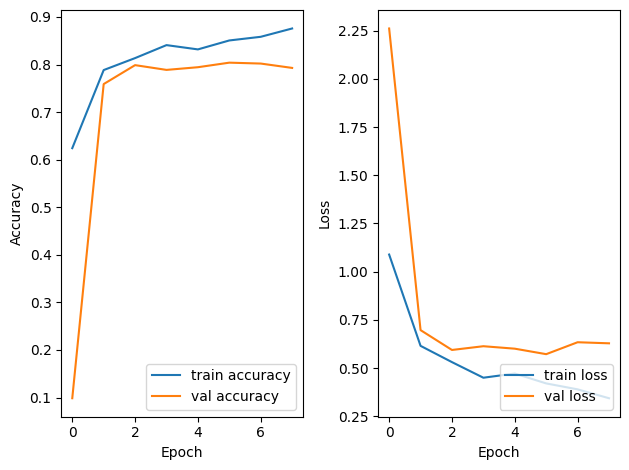

Test accuracy: 79.33%
Test loss: 0.589


100%|██████████| 118/118 [01:13<00:00,  1.60it/s]

Finished epoch 0 of 10: Train Loss = 0.346  Val Loss = 0.589   Train Acc = 0.879   Val Acc = 0.793



100%|██████████| 118/118 [01:14<00:00,  1.59it/s]

Finished epoch 1 of 10: Train Loss = 0.099  Val Loss = 0.484   Train Acc = 0.968   Val Acc = 0.847



100%|██████████| 118/118 [01:14<00:00,  1.59it/s]

Finished epoch 2 of 10: Train Loss = 0.033  Val Loss = 0.383   Train Acc = 0.992   Val Acc = 0.878



100%|██████████| 118/118 [01:13<00:00,  1.60it/s]

Finished epoch 3 of 10: Train Loss = 0.019  Val Loss = 0.332   Train Acc = 0.997   Val Acc = 0.896



100%|██████████| 118/118 [01:13<00:00,  1.60it/s]

Finished epoch 4 of 10: Train Loss = 0.009  Val Loss = 0.315   Train Acc = 0.999   Val Acc = 0.902



100%|██████████| 118/118 [01:13<00:00,  1.61it/s]

Finished epoch 5 of 10: Train Loss = 0.006  Val Loss = 0.322   Train Acc = 1.000   Val Acc = 0.912



100%|██████████| 118/118 [01:14<00:00,  1.59it/s]

Finished epoch 6 of 10: Train Loss = 0.006  Val Loss = 0.311   Train Acc = 0.999   Val Acc = 0.914



100%|██████████| 118/118 [01:13<00:00,  1.61it/s]

Finished epoch 7 of 10: Train Loss = 0.005  Val Loss = 0.305   Train Acc = 1.000   Val Acc = 0.911



100%|██████████| 118/118 [01:13<00:00,  1.60it/s]

Finished epoch 8 of 10: Train Loss = 0.004  Val Loss = 0.313   Train Acc = 1.000   Val Acc = 0.916



100%|██████████| 118/118 [01:13<00:00,  1.61it/s]

Finished epoch 9 of 10: Train Loss = 0.003  Val Loss = 0.316   Train Acc = 1.000   Val Acc = 0.914



100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


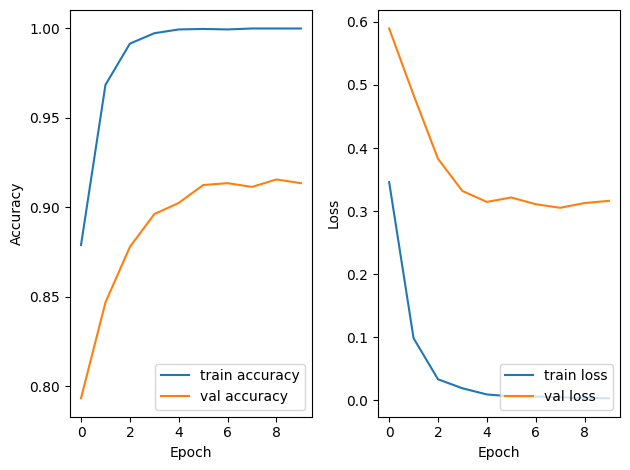

Test accuracy: 91.12%
Test loss: 0.307


TypeError: evaluate_metrics() missing 2 required positional arguments: 'dataset' and 'device'

In [14]:
# densenet121
dn = pipeline(models.densenet121(pretrained=True))

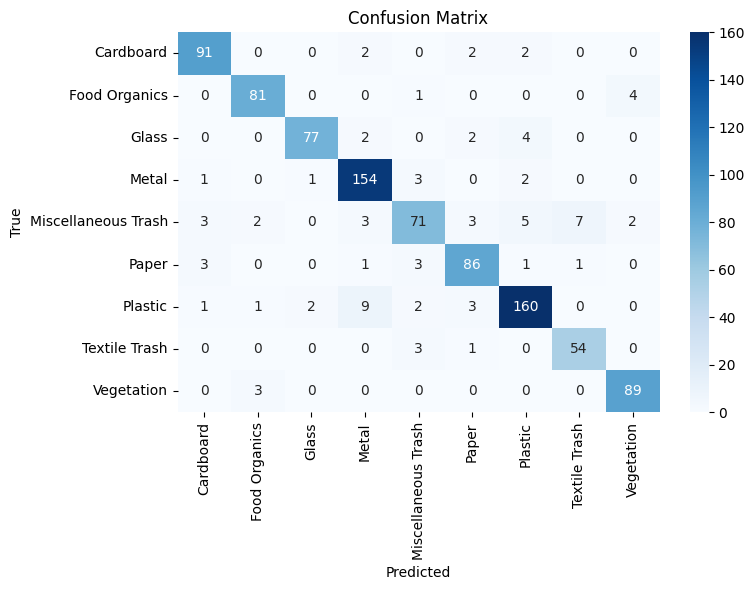


Accuracy: 0.9103
Class 0 (Cardboard): Precision: 0.9192, Recall: 0.9381, F1 Score: 0.9286
Class 1 (Food Organics): Precision: 0.9310, Recall: 0.9419, F1 Score: 0.9364
Class 2 (Glass): Precision: 0.9625, Recall: 0.9059, F1 Score: 0.9333
Class 3 (Metal): Precision: 0.9006, Recall: 0.9565, F1 Score: 0.9277
Class 4 (Miscellaneous Trash): Precision: 0.8554, Recall: 0.7396, F1 Score: 0.7933
Class 5 (Paper): Precision: 0.8866, Recall: 0.9053, F1 Score: 0.8958
Class 6 (Plastic): Precision: 0.9195, Recall: 0.8989, F1 Score: 0.9091
Class 7 (Textile Trash): Precision: 0.8710, Recall: 0.9310, F1 Score: 0.9000
Class 8 (Vegetation): Precision: 0.9368, Recall: 0.9674, F1 Score: 0.9519

Macro-Averaged Metrics:
Precision: 0.9092
Recall:    0.9094
F1 Score:  0.9085


In [17]:
# evaluate dense121
evaluate_metrics(dn, loader_test)